In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation 
pd_data = pd.read_csv("compas-analysis/compas-scores-two-years.csv") 

### Playground to visualise distribiutions of some features

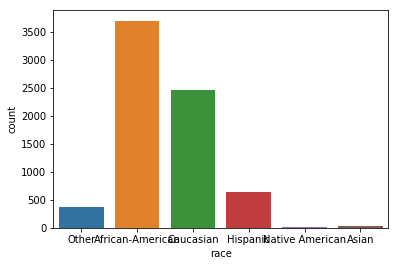

In [2]:
ax = sns.countplot(pd_data.race, orient='v')

### Selection of some features based on the article and intuition

In [3]:
to_categorise = ['sex', 'vr_charge_desc', 'race', 'c_charge_degree']
to_use = ['age','juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_days_from_compas', 'is_recid']
y_name = 'decile_score'

### Vectrorise the data

In [4]:
def just_use(column):
    return np.array(pd_data[column]).reshape(-1, 1), [column]

In [5]:
def one_hot(column):
    w = pd_data[column].value_counts()
    allowed = list(w[w > 2].index)
    convert = {name:i+1 for i, name in enumerate(allowed)}
    names = ["unknown_" + column] + [column + "_" + x for x in allowed]
    values = np.array([convert.get(v, 0) for v in pd_data[column]])
    one_hot = np.zeros((len(values), len(names) + 1))
    one_hot[np.arange(len(values)), values] = 1
    return one_hot, names

In [6]:
vectorised = [one_hot(col) for col in to_categorise] + [just_use(col) for col in to_use]
X = np.nan_to_num(np.concatenate([x[0] for x in vectorised], axis=1))
names = np.concatenate([x[1] for x in vectorised])
Y = np.array(pd_data[y_name])/10
X.shape, Y, names

((7214, 61),
 array([0.1, 0.3, 0.4, ..., 0.1, 0.2, 0.4]),
 array(['unknown_sex', 'sex_Male', 'sex_Female', 'unknown_vr_charge_desc',
        'vr_charge_desc_Battery',
        'vr_charge_desc_Felony Battery (Dom Strang)',
        'vr_charge_desc_Battery on Law Enforc Officer',
        'vr_charge_desc_Aggravated Assault W/Dead Weap',
        'vr_charge_desc_Aggrav Battery w/Deadly Weapon',
        'vr_charge_desc_Aggravated Battery / Pregnant',
        'vr_charge_desc_Felony Battery w/Prior Convict',
        'vr_charge_desc_Robbery / No Weapon',
        'vr_charge_desc_Agg Battery Grt/Bod/Harm',
        'vr_charge_desc_Assault',
        'vr_charge_desc_Agg Fleeing/Eluding High Speed',
        'vr_charge_desc_Robbery Sudd Snatch No Weapon',
        'vr_charge_desc_Aggravated Assault w/Firearm',
        'vr_charge_desc_Robbery W/Firearm', 'vr_charge_desc_Child Abuse',
        'vr_charge_desc_Stalking (Aggravated)',
        'vr_charge_desc_Burglary Dwelling Assault/Batt',
        'vr_charge

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

### Train logistic regression with keras

In [8]:
output_dim = 1
input_dim = X.shape[1]
model = Sequential() 
model.add(Dense(output_dim, input_dim=input_dim, activation='sigmoid')) 
batch_size, epochs = 128, 20
model.compile(optimizer='adam', loss='mean_squared_error') 

In [9]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=20, verbose=1, validation_data=(X_test, Y_test)) 
score = model.evaluate(X_test, Y_test, verbose=0) 
score

Train on 4833 samples, validate on 2381 samples
Epoch 1/20
4833/4833 [==============================] - 0s 67us/sample - loss: 0.1600 - val_loss: 0.1182
Epoch 2/20
4833/4833 [==============================] - 0s 13us/sample - loss: 0.1179 - val_loss: 0.1138
Epoch 3/20
4833/4833 [==============================] - 0s 14us/sample - loss: 0.1159 - val_loss: 0.1127
Epoch 4/20
4833/4833 [==============================] - 0s 13us/sample - loss: 0.1141 - val_loss: 0.1113
Epoch 5/20
4833/4833 [==============================] - 0s 14us/sample - loss: 0.1128 - val_loss: 0.1098
Epoch 6/20
4833/4833 [==============================] - 0s 14us/sample - loss: 0.1118 - val_loss: 0.1087
Epoch 7/20
4833/4833 [==============================] - 0s 13us/sample - loss: 0.1104 - val_loss: 0.1075
Epoch 8/20
4833/4833 [==============================] - 0s 13us/sample - loss: 0.1091 - val_loss: 0.1061
Epoch 9/20
4833/4833 [==============================] - 0s 14us/sample - loss: 0.1078 - val_loss: 0.1047
Epoch 1

0.045304582406935294

### Score looks good, no need to add more layers or to train a different model